In [2]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as tfs
import seaborn as sns
from torchsummary import summary
torch.cuda.set_device(0) 

In [4]:
def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/codes.csv",sep=";")[["Dx","SNOMED CT Code"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMED CT Code"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df
DATASET_NAME = "WFDB_CPSC2018"
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)


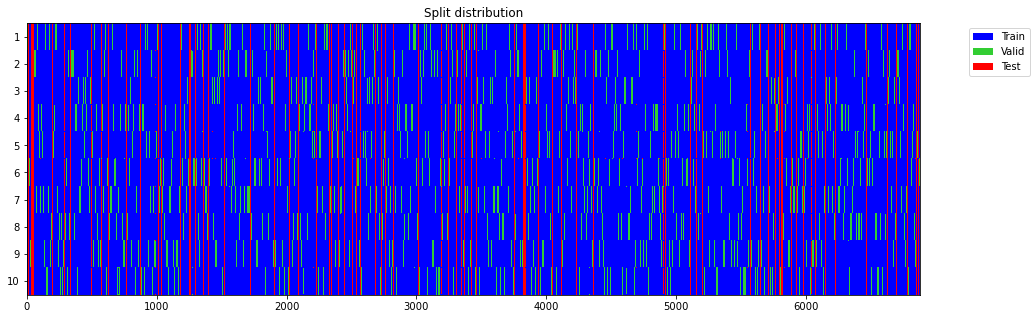

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


In [118]:

cv_splits = get_splits(y.to_numpy(), n_splits = 10, valid_size=.1,test_size=0.1, stratify=False, random_state=23, shuffle=True)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

In [261]:
import imp 
imp.reload(tfs)

<module 'transformation_funcs' from '/home/amirsalimi/ecg_augmentation/transformation_funcs.py'>

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.414265,0.321823,0.915455,0.659019,0.881892,0.323732,0.994305,0.472266,00:08
1,0.273370,0.213816,0.927841,0.715677,0.893131,0.438271,0.993083,0.587480,00:10
2,0.206102,0.189559,0.937175,0.769789,0.864705,0.550965,0.988612,0.672805,00:10
3,0.177006,0.177767,0.936457,0.788607,0.814222,0.595315,0.981899,0.687410,00:11
4,0.161367,0.175629,0.934841,0.790958,0.793260,0.602865,0.979050,0.684942,00:10
5,0.151974,0.164991,0.942201,0.814364,0.823440,0.647234,0.981493,0.724463,00:10
6,0.145107,0.172251,0.939149,0.793517,0.833742,0.603099,0.983934,0.699278,00:10
7,0.142318,0.153167,0.946868,0.813747,0.875509,0.639695,0.987799,0.738866,00:10
8,0.138479,0.156621,0.943996,0.808824,0.853180,0.632088,0.985559,0.725868,00:10
9,0.133302,0.159678,0.943996,0.818735,0.832446,0.654963,0.982507,0.732975,00:10


Better model found at epoch 0 with F1_multi value: 0.4722658693790436.


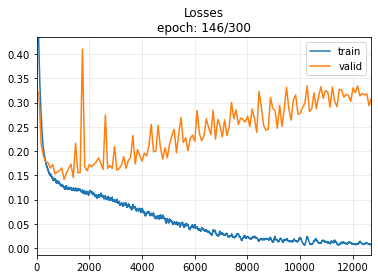

Better model found at epoch 1 with F1_multi value: 0.5874802470207214.
Better model found at epoch 2 with F1_multi value: 0.6728048324584961.
Better model found at epoch 3 with F1_multi value: 0.6874099373817444.
Better model found at epoch 5 with F1_multi value: 0.7244632244110107.
Better model found at epoch 7 with F1_multi value: 0.7388661503791809.
Better model found at epoch 11 with F1_multi value: 0.751647412776947.
Better model found at epoch 12 with F1_multi value: 0.7603359222412109.
Better model found at epoch 36 with F1_multi value: 0.7739446759223938.
Better model found at epoch 38 with F1_multi value: 0.7758499383926392.
Better model found at epoch 75 with F1_multi value: 0.7767680287361145.
Better model found at epoch 81 with F1_multi value: 0.7784245014190674.
Better model found at epoch 90 with F1_multi value: 0.7792294025421143.
Better model found at epoch 91 with F1_multi value: 0.7891610860824585.
Better model found at epoch 100 with F1_multi value: 0.795001327991485

In [ ]:
sf = 0.3
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [
#              TSStandardize(by_sample=True),
                tfs.Scale(scale_factor=sf,),
                tfs.Normalize(),
                tfs.BandPass(int(sf*500),low_cut=60, high_cut=1,leads=12,),
#               tfs.RandomShift(0.1),
#               tfs.MulNoise(6),
#               tfs.CutOutWhenTraining(),
             ]
for cv_num in range(5):
    cv_num = cv_num + 5
    dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=cv_splits[cv_num]) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    # model = MiniRocketPlus(dls.vars, dls.c,2500)
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=8,)

    learn = Learner(dls, model, metrics=metrics,
#                     opt_func = wrap_optimizer(torch.optim.Adam,weight_decay=6.614e-07),
                    cbs=[ShowGraph(),SaveModelCallback(monitor="F1_multi",fname="inception_filtered_scaled_%s"%cv_num)],
                    model_dir="models/10CV/")
    learn.fit_one_cycle(300, lr_max=0.008)
    learn.recorder.plot_metrics()

In [260]:
tfs.BandPass(int(sf*500),3,100)

BandPass:
encodes: (TSTensor,object) -> encodes
decodes: 

150

### check f1s

In [248]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [
#              TSStandardize(by_sample=True),
              tfs.Normalize(),
#                 tfs.BandPass(500,3,45),
#               tfs.RandomShift(0.1),
#               tfs.MulNoise(6),
#               tfs.CutOutWhenTraining(),
              tfs.Scale(scale_factor=sf),
              tfs.BandPass(int(sf*500),1,100),

]
reports = []
for cv_num in range(10):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=8,)
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],
                    model_dir="models/10CV/")
    learn.load("inception_filtered_scaled_%s"%cv_num)
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)

    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)

In [254]:
# for report in reports:
#     for k,v in report.items():
#         report[k] = report[k]["f1-score"]
pd.DataFrame(reports)

,1st degree av block,atrial fibrillation,left bundle branch block,premature atrial contraction,right bundle branch block,sinus rhythm,st depression,st elevation,ventricular ectopics,micro avg,macro avg,weighted avg,samples avg
0,0.827068,0.906780,0.900000,0.351648,0.925831,0.670000,0.690909,0.250000,0.674847,0.771881,0.688565,0.758384,0.738671
1,0.846154,0.926407,0.923077,0.375000,0.938776,0.695187,0.714286,0.484848,0.662722,0.789582,0.729606,0.780804,0.763707
2,0.844444,0.926407,0.871795,0.357895,0.935733,0.658537,0.744444,0.378378,0.685393,0.785912,0.711447,0.775652,0.751334
3,0.811594,0.932203,0.923077,0.377778,0.939086,0.621469,0.715026,0.344828,0.650000,0.778846,0.701673,0.764256,0.739495
4,0.842105,0.920502,0.871795,0.426471,0.935401,0.692308,0.718232,0.333333,0.626506,0.774280,0.707406,0.772389,0.753712
5,0.832117,0.957265,0.871795,0.432990,0.933333,0.655914,0.780749,0.424242,0.670886,0.798084,0.728810,0.788310,0.760311
6,0.838235,0.934426,0.809524,0.446809,0.914729,0.669856,0.691824,0.457143,0.666667,0.781357,0.714357,0.771921,0.749636
7,0.818182,0.948718,0.809524,0.430108,0.919481,0.734043,0.752941,0.476190,0.701299,0.800000,0.732276,0.791417,0.754488
8,0.869565,0.961702,0.926829,0.480769,0.941476,0.680412,0.745562,0.352941,0.670886,0.804911,0.736683,0.796393,0.767589
9,0.857143,0.940171,0.857143,0.367347,0.937500,0.717172,0.674419,0.486486,0.652482,0.788382,0.721096,0.778148,0.754973


In [203]:
for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
pd.DataFrame(reports).median()

1st degree av block             0.846465
atrial fibrillation             0.944202
left bundle branch block        0.888278
premature atrial contraction    0.446712
right bundle branch block       0.938776
sinus rhythm                    0.709516
st depression                   0.780384
st elevation                    0.488347
ventricular ectopics            0.694137
micro avg                       0.806515
macro avg                       0.745625
weighted avg                    0.800607
samples avg                     0.771470
dtype: float64

In [217]:
def label_convert(label):
    mapping = {'1st degree av block':"I-AVB",
    'atrial fibrillation':"AF",
    'left bundle branch block':"LBBB",
    'premature atrial contraction':"PAC",
    'right bundle branch block':"RBBB",
    'sinus rhythm':"normal",
    'st depression':"STD",
    'st elevation':"STE",
    'ventricular ectopics':"PVC"}
    try: 
        return mapping[label]
    except:
        return label
df = pd.DataFrame(reports)
df.columns = [label_convert(x) for x in df.columns]
sorted(dict(df[df.columns].median()).items())

[('AF', 0.9305368413587689),
 ('I-AVB', 0.8464646464646466),
 ('LBBB', 0.8717948717948718),
 ('PAC', 0.38829471182412356),
 ('PVC', 0.6731462086300797),
 ('RBBB', 0.9354067624592703),
 ('STD', 0.7508747606786823),
 ('STE', 0.43843843843843844),
 ('macro avg', 0.7288329932996207),
 ('micro avg', 0.7967174539182653),
 ('normal', 0.7190058479532164),
 ('samples avg', 0.7512615235322659),
 ('weighted avg', 0.7874846913495377)]

In [218]:
dict(df[df.columns].median())

{'I-AVB': 0.8464646464646466,
 'AF': 0.9305368413587689,
 'LBBB': 0.8717948717948718,
 'PAC': 0.38829471182412356,
 'RBBB': 0.9354067624592703,
 'normal': 0.7190058479532164,
 'STD': 0.7508747606786823,
 'STE': 0.43843843843843844,
 'PVC': 0.6731462086300797,
 'micro avg': 0.7967174539182653,
 'macro avg': 0.7288329932996207,
 'weighted avg': 0.7874846913495377,
 'samples avg': 0.7512615235322659}

In [236]:
winner = dict(zip(["normal","AF","I-AVB","LBBB","RBBB","PAC","PVC","STD","STE"],[0.795,0.897,0.865,0.821,0.911,0.734,0.852,0.788,0.509]))
winner_ensemble = dict(zip(["normal","AF","I-AVB","LBBB","RBBB","PAC","PVC","STD","STE"],[0.808,0.933,0.875,0.884,0.910,0.826,0.869,0.811,0.624]))
inception_no_augment = dict(zip(["RBBB","PVC","AF","LBBB","STE","I-AVB","PAC","normal","STD"],[0.944,0.715,0.939,0.891,0.482,0.833,0.505, 0.709,0.789]))
# inception_augmented = dict(zip(["RBBB","PVC","AF","LBBB","STE","I-AVB","PAC","normal","STD"],[0.935,0.682,0.944,0.884,0.450,0.846,0.474, 0.731,0.778]))
inception_augmented = dict({'I-AVB': 0.8464646464646466,
                             'AF': 0.9442018973933868,
                             'LBBB': 0.8882783882783882,
                             'PAC': 0.44671201814058953,
                             'RBBB': 0.9387755102040817,
                             'normal': 0.7095162569389373,
                             'STD': 0.7803842940685046,
                             'STE': 0.4883468834688347,
                             'PVC': 0.694136741732603,})
inception_scaled_only = dict({
                        'I-AVB': 0.8464646464646466,
                         'AF': 0.9429286608260325,
                         'LBBB': 0.8717948717948718,
                         'PAC': 0.454995499549955,
                         'RBBB': 0.9367724233463863,
                         'normal': 0.6970246316758748,
                         'STD': 0.765686274509804,
                         'STE': 0.46785225718194257,
                         'PVC': 0.68630634479812,})
inception_normal_only = dict({
                            'I-AVB': 0.8464646464646466,
                             'AF': 0.9305368413587689,
                             'LBBB': 0.8717948717948718,
                             'PAC': 0.38829471182412356,
                             'RBBB': 0.9354067624592703,
                             'normal': 0.7190058479532164,
                             'STD': 0.7508747606786823,
                             'STE': 0.43843843843843844,
                             'PVC': 0.6731462086300797,
                        })

winner = dict(sorted(winner.items()))
winner_ensemble = dict(sorted(winner_ensemble.items()))
inception = dict(sorted(inception.items()))
inception_augmented = dict(sorted(inception_augmented.items()))
df = pd.DataFrame([winner_ensemble,inception_augmented,inception_scaled_only,inception_normal_only],index=["winner_ensemble","inception_augmented","inception_scaled_only","inception_normal_only"]).T
df["performance"] = df["winner_ensemble"]<df["inception_augmented"]
df

,winner_ensemble,inception_augmented,inception_scaled_only,inception_normal_only,performance
AF,0.933,0.944202,0.942929,0.930537,True
I-AVB,0.875,0.846465,0.846465,0.846465,False
LBBB,0.884,0.888278,0.871795,0.871795,True
PAC,0.826,0.446712,0.454995,0.388295,False
PVC,0.869,0.694137,0.686306,0.673146,False
RBBB,0.910,0.938776,0.936772,0.935407,True
STD,0.811,0.780384,0.765686,0.750875,False
STE,0.624,0.488347,0.467852,0.438438,False
normal,0.808,0.709516,0.697025,0.719006,False


In [237]:
df.mean()

winner_ensemble          0.837778
inception_augmented      0.748535
inception_scaled_only    0.741092
inception_normal_only    0.728218
performance              0.333333
dtype: float64